# Getting Started

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
# get to the parent dir of mai_dul repo
import os

# os.chdir('../../')
os.getcwd()

'C:\\Users\\k67887\\PycharmProjects\\MAI_DUL_WS24\\homeworks\\hw3'

In [2]:
# install latest version deepul package
# !pip install -e .

In [3]:
from deepul.hw3_helper import *
import deepul.pytorch_util as ptu
import warnings
import numpy as np
import torch
from deepul.hw3_helper import q1_save_results
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

from models.GAN1 import GAN1Generator, GAN1Discriminator
from torch.nn import functional as F
import matplotlib

warnings.filterwarnings('ignore')

In [4]:
ptu.set_gpu_mode(True)

# Question 1: Warmup [20pt]

In this question, we will train different variants of GANs on an easy 1D dataset. 

Execute the cell below to visualize our datasets.

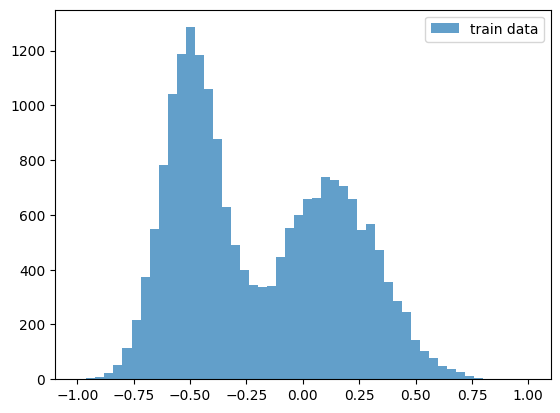

In [5]:
visualize_q1_dataset()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook


## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 
* 3 layers
* 128 hidden dim
* LeakyReLU nonlinearities with negative_slope=0.2

### Solution

In [7]:
def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at the end of training
    """

    """ YOUR CODE HERE """
    n_features = train_data.shape[1]
    learning_rate = 0.0001
    batch_size = 128
    max_epochs = 200

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    generator = GAN1Generator().to(device)
    discriminator = GAN1Discriminator().to(device)
    optimizer_d = Adam(discriminator.parameters(), lr=learning_rate)
    optimizer_g = Adam(generator.parameters(), lr=learning_rate)
    train_losses = []

    samples1 = generator.generate(5000, device).numpy(force=True)
    xs1 = np.linspace(-1, 1, 1000)
    ys1 = discriminator.forward(torch.tensor(xs1, dtype=torch.float).unsqueeze(-1).to(device)).numpy(force=True)
    for epoch in tqdm(range(max_epochs)):
        # train discriminator
        for i, [batch] in enumerate(iter(train_loader)):
            x = batch.to(device)
            x_fake = generator.forward(torch.randn(batch.shape).to(device))
            y_real = torch.ones(x.shape[0], 1).to(device)
            y_fake = torch.zeros(x_fake.shape[0], 1).to(device)
            loss = (F.binary_cross_entropy(discriminator.forward(x), y_real) +
                    F.binary_cross_entropy(discriminator.forward(x_fake), y_fake))
            loss.backward()
            train_losses.append(loss.item())
            optimizer_d.step()
            optimizer_d.zero_grad()

            # argmax = flip gradients then step
            with torch.no_grad():
                for p in generator.parameters():
                    p.grad = -p.grad
            optimizer_g.step()
            optimizer_g.zero_grad()

    train_losses = np.array(train_losses)

    samples_end = generator.generate(5000, device).numpy(force=True)
    xs_end = np.linspace(-1, 1, 1000)
    ys_end = discriminator.forward(torch.tensor(xs1, dtype=torch.float).unsqueeze(-1).to(device)).numpy(force=True)
    return train_losses, samples1, xs1, ys1, samples_end, xs_end, ys_end


### Results

100%|██████████| 200/200 [01:43<00:00,  1.93it/s]


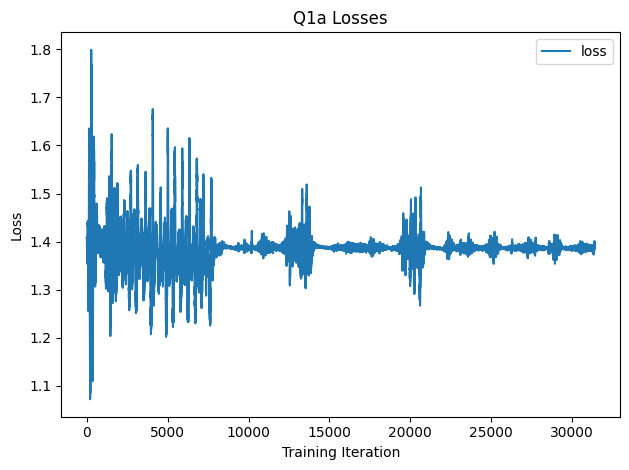

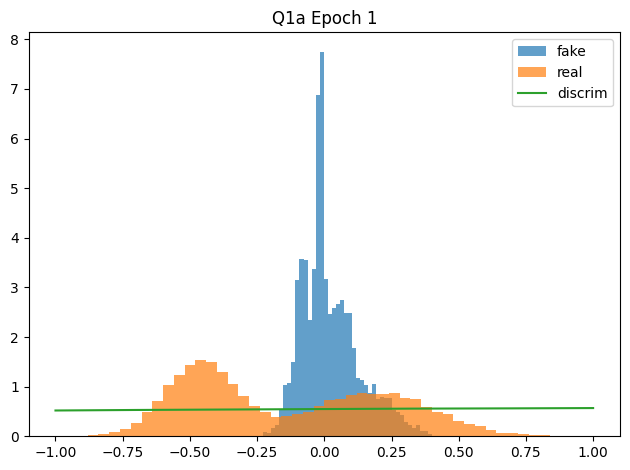

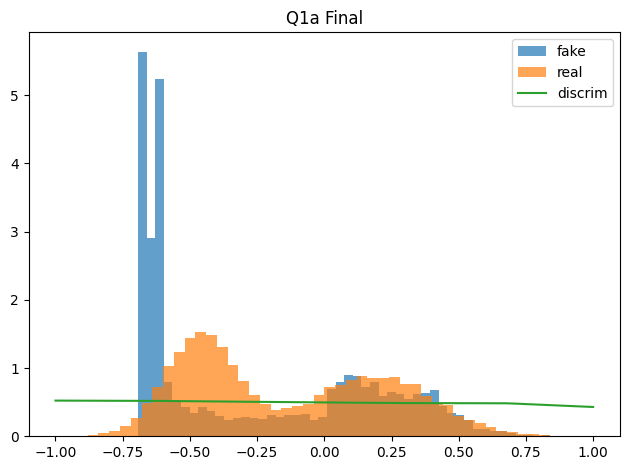

In [8]:
q1_save_results('a', q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate objectives:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G)} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z)))$$

 ### Solution

In [12]:
def q1_b(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at the end of training
    """

    """ YOUR CODE HERE """
    learning_rate = 0.0001
    batch_size = 128
    max_epochs = 200

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataset = TensorDataset(torch.tensor(train_data, dtype=torch.float))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    generator = GAN1Generator().to(device)
    discriminator = GAN1Discriminator().to(device)
    optimizer_d = Adam(discriminator.parameters(), lr=learning_rate)
    optimizer_g = Adam(generator.parameters(), lr=learning_rate)
    train_losses_d = []
    train_losses_g = []

    samples1 = generator.generate(5000, device).numpy(force=True)
    xs1 = np.linspace(-1, 1, 1000)
    ys1 = discriminator.forward(torch.tensor(xs1, dtype=torch.float).unsqueeze(-1).to(device)).numpy(force=True)
    for epoch in tqdm(range(max_epochs)):
        # train discriminator
        for i, [batch] in enumerate(iter(train_loader)):
            optimizer_d.zero_grad()
            x = batch.to(device)
            x_fake = generator.forward(torch.randn(batch.shape).to(device))
            y_real = torch.ones(x.shape[0], 1).to(device)
            y_fake = torch.zeros(x_fake.shape[0], 1).to(device)
            loss_d = (F.binary_cross_entropy(discriminator.forward(x), y_real) +
                      F.binary_cross_entropy(discriminator.forward(x_fake), y_fake))
            loss_d.backward()
            optimizer_d.step()
            train_losses_d.append(loss_d.item())

            optimizer_g.zero_grad()
            x_fake = generator.forward(torch.randn(batch.shape).to(device))
            loss_g = F.binary_cross_entropy(discriminator.forward(x_fake), y_real)
            loss_g.backward()
            train_losses_g.append(loss_g.item())
            optimizer_g.step()

    train_losses_d = np.array(train_losses_d)

    samples_end = generator.generate(5000, device).numpy(force=True)
    xs_end = np.linspace(-1, 1, 1000)
    ys_end = discriminator.forward(torch.tensor(xs1, dtype=torch.float).unsqueeze(-1).to(device)).numpy(force=True)
    return train_losses_d, samples1, xs1, ys1, samples_end, xs_end, ys_end



 ### Results

100%|██████████| 200/200 [02:48<00:00,  1.19it/s]


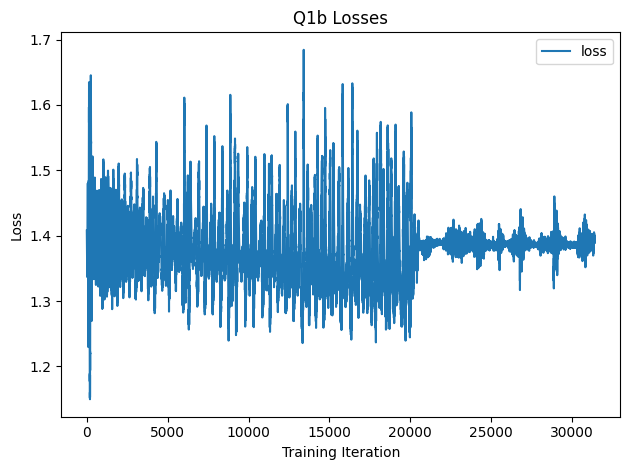

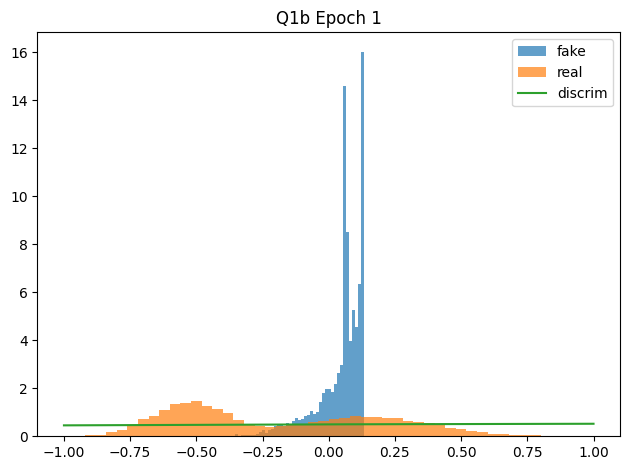

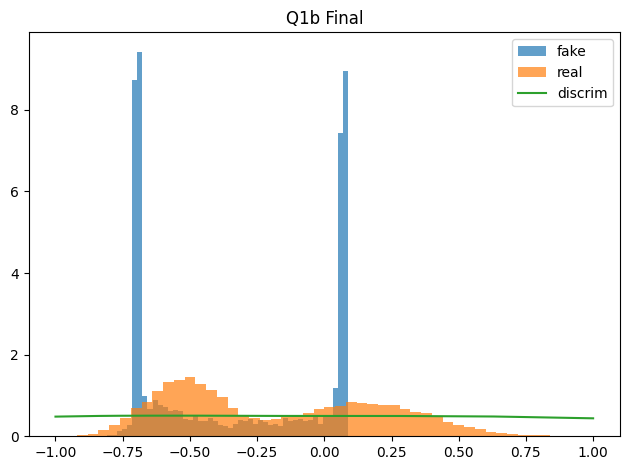

In [13]:
q1_save_results('b', q1_b)